# Triplet STDP synapse tutorial

In this tutorial, we will learn to formulate triplet rule (which considers sets of three spikes, i.e., two presynaptic and one postsynaptic spikes or two postsynaptic and one presynaptic spikes) for Spike Timing-Dependent Plasticity (STDP) learning model using NESTML and simulate it with NEST simulator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

np.set_printoptions(suppress=True)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Dec 10 2024 12:04:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Early experiments in Bi and Poo (1998) [1] have shown that a sequence of $n$ pairs of "pre then post" spikes result in synaptic potentiation and $n$ pairs of "post then pre" result in synaptic depression. Later experiments have shown that these pairs of spikes do not necessarily describe the synaptic plasiticity behavior. Other variables like calcium concentration or postsynaptic membrane potential play an important role in potentiation or depression.

Experiments conducted by Wang et al., [2] and Sjöström et al., [3] using triplet and quadruplets of spikes show that the classical spike-dependent synaptic plasticity alone cannot explain the results of the experiments. The triplet STDP model formulated by Pfister and Gerstner in [4] assume that a combination of pairs and triplets of spikes triggers the synaptic plasticity and thus reproduce the experimental results.

## Triplet STDP model

The synaptic transmission is formulated by a set of four differential equations as defined below.

\begin{equation}
\frac{dr_1}{dt} = -\frac{r_1(t)}{\tau_+} \quad
\text{if } t = t^{pre}, \text{ then } r_1 \rightarrow r_1+1
\end{equation}

\begin{equation}
\frac{dr_2}{dt} = -\frac{r_2(t)}{\tau_x} \quad
\text{if } t = t^{pre}, \text{ then } r_2 \rightarrow r_2+1
\end{equation}

\begin{equation}
\frac{do_1}{dt} = -\frac{o_1(t)}{\tau_-} \quad
\text{if } t = t^{post}, \text{ then } o_1 \rightarrow o_1+1
\end{equation}

\begin{equation}
\frac{do_2}{dt} = -\frac{o_2(t)}{\tau_y} \quad
\text{if } t = t^{post}, \text{ then } o_2 \rightarrow o_2+1
\end{equation}

Here, $r_1$ and $r_2$ are the trace variables that detect the presynaptic events when a spike occurs at the presynaptic neuron at time $t^{pre}$. These variables increase when a presynaptic spike occurs and decrease back to 0 otherwise with time constants $\tau_+$ and $\tau_x$ respectively. Similarly, the variables $o_1$ and $o_2$ denote the trace variables that detect the postsynaptic events at a spike time $t^{post}$. In the absence of a postsynaptic spike, the vairables decrease their value with a time constant $\tau_-$ and $\tau_y$ respectively. Presynaptic variables, for example, can be the amount of glutamate bound and the postsynaptic receptors can determine the influx of calcium concentration through voltage-gated $Ca^{2+}$ channels.

The weight change in the model is formulated as a function of the four trace variables defined above. The weight of the synapse decreases after the presynaptic spikes arrives at $t^{pre}$ by an amount proportional to the postsynaptic variable $o_1$ but also depends on the second presynaptic variable $r_2$.

\begin{equation}
w(t) \rightarrow w(t) - o_1(t)[A_2^- + A_3^- r_2(t - \epsilon)] \quad \text{if } t = t^{pre}
\end{equation}

Similarly, a postsynaptic spike at time $t^{post}$ increases the weight of the synapse and is dependent on the presynaptic variable $r_1$ and the postsynaptic variable $o_2$.

\begin{equation}
w(t) \rightarrow w(t) + r_1(t)[A_2^+ + A_3^+ o_2(t - \epsilon)] \quad \text{if } t = t^{post}
\end{equation}

Here, $A_2^+$ and $A_2^-$ denote the amplitude of the weight change whenever there is a pre-post pair or a post-pre pair. Similarly, $A_3^+$ and $A_3^-$ denote the amplitude of the triplet term for potentiation and depression, respectively.

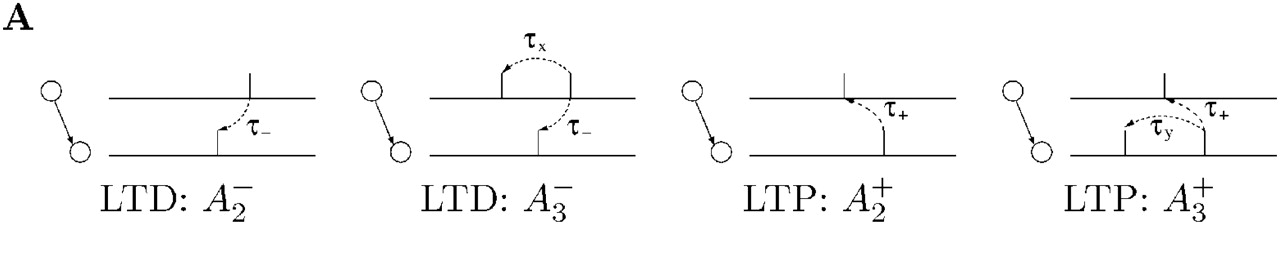

## Generating code with NESTML

### Triplet STDP model in NESTML

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential, the "iaf_psc_delta" model. It is already provided with NESTML in the `models/neurons` directory.

We will be formulating two types of interactions between the spikes, namely All-to-All interaction and Nearest-spike interaction.

$\textit{All-to-All Interaction}$ - Each postsynaptic spike interacts with all previous postsynaptic spikes and vice versa. All the internal variables $r_1, r_2, o_1,$ and $o_2$ accumulate over several postsynaptic spike timimgs.

<div>
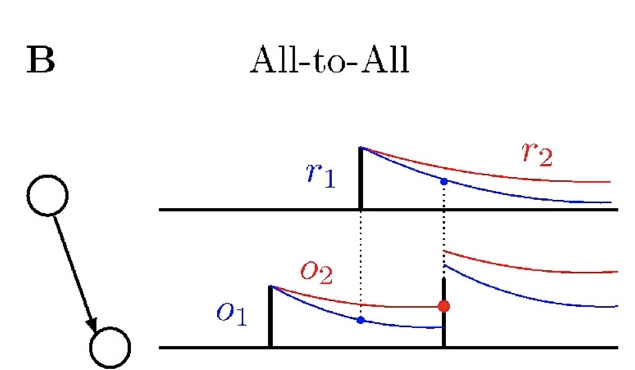
</div>

In [2]:
nestml_triplet_stdp_model = """
model stdp_triplet_synapse:

    state:
        w nS = 1 nS

        tr_r1 real = 0.
        tr_r2 real = 0.
        tr_o1 real = 0.
        tr_o2 real = 0.

    parameters:
        d ms = 1 ms

        tau_plus ms = 16.8 ms  # time constant for tr_r1
        tau_x ms = 101 ms  # time constant for tr_r2
        tau_minus ms = 33.7 ms  # time constant for tr_o1
        tau_y ms = 125 ms  # time constant for tr_o2

        A2_plus real = 7.5e-10
        A3_plus real = 9.3e-3
        A2_minus real = 7e-3
        A3_minus real = 2.3e-4

        Wmax nS = 100 nS
        Wmin nS = 0 nS

    equations:
        tr_r1' = -tr_r1 / tau_plus
        tr_r2' = -tr_r2 / tau_x
        tr_o1' = -tr_o1 / tau_minus
        tr_o2' = -tr_o2 / tau_y

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike(weight real, delay ms)

    onReceive(post_spikes):
        # increment post trace values
        tr_o1 += 1
        tr_o2 += 1

        # potentiate synapse
        w_ nS = w + tr_r1 * ( A2_plus + A3_plus * tr_o2 )
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        # increment pre trace values
        tr_r1 += 1
        tr_r2 += 1

        # depress synapse
        w_ nS = w  -  tr_o1 * ( A2_minus + A3_minus * tr_r2 )
        w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        emit_spike(w, d)
        
    update:
        integrate_odes()
"""

In [3]:
# Generate code for All-to-All spike interaction
module_name, neuron_model_name, synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/iaf_psc_delta_neuron.nestml",
                                             nestml_triplet_stdp_model,
                                             post_ports=["post_spikes"],
                                             logging_level="WARNING",
                                             codegen_opts={"delay_variable": {"stdp_triplet_synapse": "d"},
                                                           "weight_variable": {"stdp_triplet_synapse": "w"}})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Dec 10 2024 12:04:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[13,stdp_triplet_synapse_nestml, WARNING, [47:16;47:16]]: Implicit casting from (compatible) type 'nS' to 'real'.
[16,stdp_triplet_synapse_nestml, WARNING, [56:16;56:16]]: Implicit casting from (compatible) type 'nS' to 'real'.
[19,stdp_triplet_synapse_nestml, WARNING, [13:8;13:17]]: Variable 'd' has the same name as a physical unit!
[20,stdp_triplet_synapse_nestml, WARNING, [38:4;39:4]]: Implicit casting from (compatible) type 'real' to 'nS'.


$\textit{Nearest spike Interation}$ - Each postsynaptic spike interacts with only the last spike. Hence no accumulation of the trace variables occurs. The variables saturate at 1. This is achieved by updating the variables to the value of 1 instead of updating by at step of 1. In this way, the synapse forgets all other previous spikes and keeps only the memory of the last one.

<div>
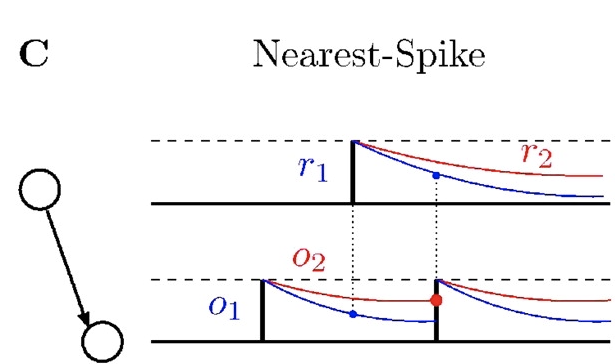
</div>

In [4]:
nestml_triplet_stdp_nn_model = """
model stdp_triplet_nn_synapse:

    state:
        w nS = 1 nS

        tr_r1 real = 0.
        tr_r2 real = 0.
        tr_o1 real = 0.
        tr_o2 real = 0.

    parameters:
        d ms = 1 ms

        tau_plus ms = 16.8 ms  # time constant for tr_r1
        tau_x ms = 101 ms  # time constant for tr_r2
        tau_minus ms = 33.7 ms  # time constant for tr_o1
        tau_y ms = 125 ms  # time constant for tr_o2

        A2_plus real = 7.5e-10
        A3_plus real = 9.3e-3
        A2_minus real = 7e-3
        A3_minus real = 2.3e-4

        Wmax nS = 100 nS
        Wmin nS = 0 nS

    equations:
        tr_r1' = -tr_r1 / tau_plus
        tr_r2' = -tr_r2 / tau_x
        tr_o1' = -tr_o1 / tau_minus
        tr_o2' = -tr_o2 / tau_y

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike(weight real, delay ms)

    onReceive(post_spikes):
        # increment post trace values
        tr_o1 = 1
        tr_o2 = 1

        # potentiate synapse
        #w_ nS = Wmax * ( w / Wmax + tr_r1 * ( A2_plus + A3_plus * tr_o2 ) )
        w_ nS = w + tr_r1 * ( A2_plus + A3_plus * tr_o2 )
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        # increment pre trace values
        tr_r1 = 1
        tr_r2 = 1

        # depress synapse
        #w_ nS = Wmax * ( w / Wmax  -  tr_o1 * ( A2_minus + A3_minus * tr_r2 ) )
        w_ nS = w  -  tr_o1 * ( A2_minus + A3_minus * tr_r2 )
        w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        emit_spike(w, d)
        
    update:
        integrate_odes()
"""

In [5]:
# Generate code for nearest spike interaction model
module_name_nn, neuron_model_name_nn, synapse_model_name_nn = \
    NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/iaf_psc_delta_neuron.nestml",
                                             nestml_triplet_stdp_nn_model,
                                             post_ports=["post_spikes"],
                                             codegen_opts={"delay_variable": {"stdp_triplet_nn_synapse": "d"},
                                                           "weight_variable": {"stdp_triplet_nn_synapse": "w"}})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Dec 10 2024 12:04:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[13,stdp_triplet_nn_synapse_nestml, WARNING, [48:16;48:16]]: Implicit casting from (compatible) type 'nS' to 'real'.
[16,stdp_triplet_nn_synapse_nestml, WARNING, [58:16;58:16]]: Implicit casting from (compatible) type 'nS' to 'real'.
[19,stdp_triplet_nn_synapse_nestml, WARNING, [13:8;13:17]]: Variable 'd' has the same name as a physical unit!
[20,stdp_triplet_nn_synapse_nestml, WARNING, [38:4;39:4]]: Implicit casting from (compatible) type 'real' to 'nS'.


## Results 

###  Spike pairing protocol

If we set the values of $A_3^+$ and $A_3^-$ to 0 in the above equations, the model becomes a classical STDP model. The authors in [4] tested this model to check if they could reproduce the experimental results of [2] and [3]. They tested this with a pairing protocol which is a classic STDP protocol where the pairs of presynaptic and postsynaptic spikes shifted by $\Delta{t}$ are repeated at regular intervals of $(1/\rho)$. They showed that spike pairs repeated at high frequencies did not have considerable effect on the synaptic weights as shown by the experimental data.


<div>
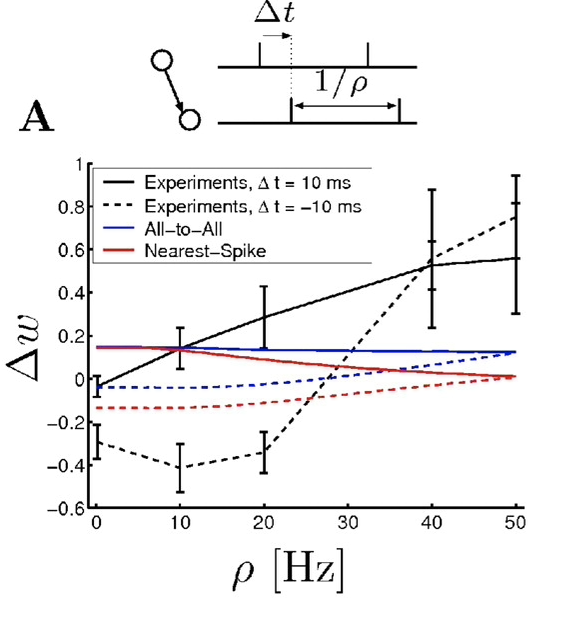
</div>


### Triplet STDP model with spike pairs

Let us simulate the pairing protocol in the above formulated model to see if we can reproduce the frequency dependence of spikes on the synaptic weights.

In [6]:
# Create pre and post spike arrays
def create_spike_pairs(freq=1., delta_t=0., size=10):
    """
    Creates the spike pairs given the frequency and the time difference between the pre and post spikes.
    :param: freq: frequency of the spike pairs
    :param: delta_t: time difference or delay between the spikes
    :param: size: number of spike pairs to be generated.
    :return: pre and post spike arrays
    """
    pre_spike_times = 1 + abs(delta_t) + freq * np.arange(size).astype(float)
    post_spike_times = 1 + abs(delta_t) + delta_t + freq * np.arange(size).astype(float)
    
    return pre_spike_times, post_spike_times

In [7]:
def run_triplet_stdp_network(module_name, neuron_model_name, synapse_model_name, neuron_opts,
                             nest_syn_opts, pre_spike_times, post_spike_times, 
                             resolution=1., delay=1., sim_time=None):
    """
    Runs the triplet stdp synapse model
    """
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")
    nest.print_time = False
    nest.SetKernelStatus({"resolution": resolution})
    nest.Install(module_name)
    
    # Set defaults for neuron
    nest.SetDefaults(neuron_model_name, neuron_opts)

    # Create neurons
    neurons = nest.Create(neuron_model_name, 2)

    pre_sg = nest.Create("spike_generator", params={"spike_times": pre_spike_times})
    post_sg = nest.Create("spike_generator", params={"spike_times": post_spike_times})

    spikes = nest.Create("spike_recorder")
    weight_recorder = nest.Create("weight_recorder")

    # Set defaults for synapse
    nest.CopyModel("static_synapse",
                   "excitatory_noise",
                   {"weight": 9999.,
                    "delay" : syn_opts["delay"]})

    _syn_opts = nest_syn_opts.copy()
    _syn_opts.pop("delay")

    nest.CopyModel(synapse_model_name,
                       synapse_model_name + "_rec",
                       {"weight_recorder"   : weight_recorder[0]})
    nest.SetDefaults(synapse_model_name + "_rec", _syn_opts)

    # Connect nodes
    nest.Connect(neurons[0], neurons[1], syn_spec={"synapse_model": synapse_model_name + "_rec"})
    nest.Connect(pre_sg, neurons[0], syn_spec="excitatory_noise")
    nest.Connect(post_sg, neurons[1], syn_spec="excitatory_noise")
    nest.Connect(neurons, spikes)
    
    # Run simulation
    syn = nest.GetConnections(source=neurons[0], synapse_model=synapse_model_name + "_rec")
    initial_weight = nest.GetStatus(syn)[0]["w"]
    
    nest.Simulate(sim_time)
    
    updated_weight = nest.GetStatus(syn)[0]["w"]
    dw = updated_weight - initial_weight
    print("Initial weight: {}, Updated weight: {}".format(initial_weight, updated_weight))

    connections = nest.GetConnections(neurons, neurons)
    gid_pre = nest.GetStatus(connections,"source")[0]
    gid_post = nest.GetStatus(connections,"target")[0]

    # From the spike recorder
    events = nest.GetStatus(spikes, "events")[0]
    times_spikes = np.array(events["times"])
    senders_spikes = events["senders"]
    # print("times_spikes: ", times_spikes)
    # print("senders_spikes: ", senders_spikes)

    # From the weight recorder
    events = nest.GetStatus(weight_recorder, "events")[0]
    times_weights = events["times"]
    weights = events["weights"]
    # print("times_weights: ", times_weights)
    # print("weights: ", weights)
    
    return dw

### Simulation

In [8]:
# Simulate the network
def run_frequency_simulation(module_name, neuron_model_name, synapse_model_name,
                             neuron_opts, nest_syn_opts,
                             freqs, delta_t, n_spikes):
    """
    Runs the spike pair simulation for given frequencies and given time difference between spikes.
    """
    dw_dict = dict.fromkeys(delta_t)
    for _t in delta_t:
        dw_vec = []
        for _freq in freqs:
            spike_interval = (1/_freq)*1000 # in ms

            pre_spike_times, post_spike_times = create_spike_pairs(freq=spike_interval,
                                                                   delta_t=_t,
                                                                   size=n_spikes)

            sim_time = max(np.amax(pre_spike_times), np.amax(post_spike_times)) + 10. + 3 * syn_opts["delay"]

            dw = run_triplet_stdp_network(module_name, neuron_model_name, synapse_model_name, 
                                          neuron_opts, nest_syn_opts,
                                          pre_spike_times=pre_spike_times,
                                          post_spike_times=post_spike_times,
                                          sim_time=sim_time)
            dw_vec.append(dw)

        dw_dict[_t] = dw_vec
        
    return dw_dict

### All-to-all spike interaction

In [9]:
freqs = [1., 5., 10., 20., 40., 50.] # frequency of spikes in Hz
delta_t = [10, -10] # delay between t_post and t_pre in ms
n_spikes = 60

In [10]:
syn_opts = {
        "delay": 1.,
        "tau_minus": 33.7,
        "tau_plus": 16.8,
        "tau_x": 101.,
        "tau_y": 125.,
        "A2_plus": 5e-10,
        "A3_plus": 6.2e-3,
        "A2_minus": 7e-3,
        "A3_minus": 2.3e-4,
        "Wmax":  50.,
        "Wmin" : 0.,
        "w": 1.
}

synapse_suffix = neuron_model_name[neuron_model_name.find("_with_")+6:]
neuron_opts = {"tau_minus__for_" + synapse_suffix: syn_opts["tau_minus"],
                "tau_y__for_" + synapse_suffix: syn_opts["tau_y"]}

nest_syn_opts = syn_opts.copy()
nest_syn_opts.pop("tau_minus")
nest_syn_opts.pop("tau_y")

dw_dict = run_frequency_simulation(module_name, neuron_model_name, synapse_model_name, 
                                   neuron_opts, nest_syn_opts,
                                   freqs, delta_t, n_spikes)

Initial weight: 1.0, Updated weight: 1.1901198652513312
Initial weight: 1.0, Updated weight: 1.235540139157801
Initial weight: 1.0, Updated weight: 1.308614896811808
Initial weight: 1.0, Updated weight: 1.4054148085640132
Initial weight: 1.0, Updated weight: 1.662941158822668
Initial weight: 1.0, Updated weight: 1.8524602513162671
Initial weight: 1.0, Updated weight: 0.6678711978627694
Initial weight: 1.0, Updated weight: 0.6653468372243871
Initial weight: 1.0, Updated weight: 0.6467070674250393
Initial weight: 1.0, Updated weight: 0.6515909471021578
Initial weight: 1.0, Updated weight: 1.250133045709924
Initial weight: 1.0, Updated weight: 1.8648234631065448


### Nearest spike interaction

In [11]:
syn_opts_nn = {
        "delay": 1.,
        "tau_minus": 33.7,
        "tau_plus": 16.8,
        "tau_x": 714.,
        "tau_y": 40.,
        "A2_plus": 8.8e-11,
        "A3_plus": 5.3e-2,
        "A2_minus": 6.6e-3,
        "A3_minus": 3.1e-3,
        "Wmax":  50.,
        "Wmin" : 0.,
        "w": 1.
}

synapse_suffix_nn = neuron_model_name_nn[neuron_model_name_nn.find("_with_")+6:]
neuron_opts_nn = {"tau_minus__for_" + synapse_suffix_nn: syn_opts_nn["tau_minus"],
                  "tau_y__for_" + synapse_suffix_nn: syn_opts_nn["tau_y"]}

nest_syn_opts_nn = syn_opts_nn.copy()
nest_syn_opts_nn.pop("tau_minus")
nest_syn_opts_nn.pop("tau_y")

dw_dict_nn = run_frequency_simulation(module_name_nn, neuron_model_name_nn, synapse_model_name_nn,
                                      neuron_opts_nn, nest_syn_opts_nn,
                                      freqs, delta_t, n_spikes)

Initial weight: 1.0, Updated weight: 2.6246821154342213
Initial weight: 1.0, Updated weight: 2.6225833385813484
Initial weight: 1.0, Updated weight: 2.5838808223349936
Initial weight: 1.0, Updated weight: 2.4447835260633717
Initial weight: 1.0, Updated weight: 2.2469319412160247
Initial weight: 1.0, Updated weight: 2.186514721685051
Initial weight: 1.0, Updated weight: 0.554406040254968
Initial weight: 1.0, Updated weight: 0.5544421490699917
Initial weight: 1.0, Updated weight: 0.5682959504659251
Initial weight: 1.0, Updated weight: 0.8268282674672477
Initial weight: 1.0, Updated weight: 1.760869268712827
Initial weight: 1.0, Updated weight: 2.1790881556893003


### Plot: Weight change as a function of frequency

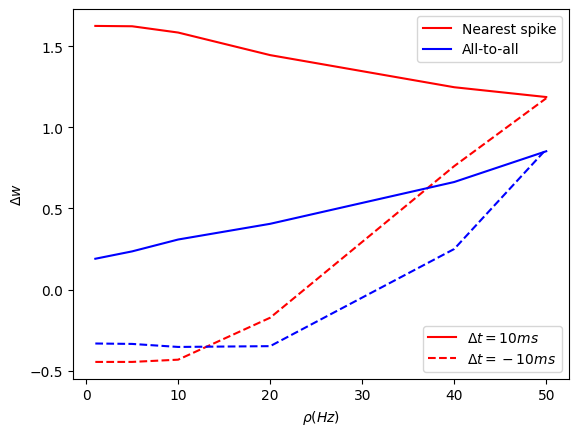

In [12]:
%matplotlib inline
fig, axes = plt.subplots()
ls1 = axes.plot(freqs, dw_dict_nn[delta_t[0]], color="r")
ls2 = axes.plot(freqs, dw_dict_nn[delta_t[1]], linestyle="--", color="r")
axes.plot(freqs, dw_dict[delta_t[0]], color="b")
axes.plot(freqs, dw_dict[delta_t[1]], linestyle="--", color="b")

axes.set_xlabel(r"${\rho}(Hz)$")
axes.set_ylabel(r"${\Delta}w$")

lines = axes.get_lines()
legend = plt.legend([lines[i] for i in [0,2]], ["Nearest spike", "All-to-all"])
legend2 = plt.legend([ls1[0], ls2[0]], [r"${\Delta}t = 10ms$", r"${\Delta}t = -10ms$"], loc = 4)
axes.add_artist(legend)
plt.show()
plt.close(fig)


### Triplet protocol

In the first triplet protocol, each triplet consists of two presynaptic spikes and one postsynaptic spike separated by $\Delta{t_1} = t^{post} - t_1^{pre}$ and $\Delta{t_2} = t^{post} - t_2^{pre}$ where $t_1^{pre}$ and $t_2^{pre}$ are the presynaptic spikes of the triplet. 

The second triplet protocol is similar to the first with the difference that it contains two postsynaptic spikes and one presynaptic spike. In this case, $\Delta{t_1} = t_1^{post} - t^{pre}$ and $\Delta{t_2} = t_2^{post} - t^{pre}$.

In [13]:
def create_triplet_spikes(_delays, n, trip_delay=1):
    _dt1 = abs(_delays[0])
    _dt2 = abs(_delays[1])
    _interval = _dt1 + _dt2
    
    # pre_spikes
    start = 1
    stop = 0
    pre_spike_times = []
    for i in range(n):
        start = stop + 1 if i == 0 else stop + trip_delay
        stop = start + _interval
        pre_spike_times = np.hstack([pre_spike_times, [start, stop]])
    
    # post_spikes
    start = 1 + _dt1
    step = _interval + trip_delay
    stop = start + n * step
    post_spike_times = np.arange(start, stop, step).astype(float)
    
    return pre_spike_times, post_spike_times

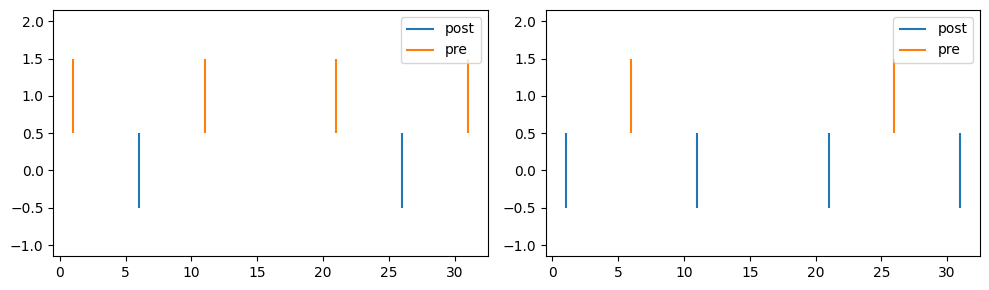

In [14]:
pre_spike_times, post_spike_times = create_triplet_spikes((5, -5), 2, 10)
l = []
l.append(post_spike_times)
l.append(pre_spike_times)
colors1 = ["C{}".format(i) for i in range(2)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.eventplot(l, colors=colors1)
ax1.legend(["post", "pre"])

l = []
l.append(pre_spike_times)
l.append(post_spike_times)
ax2.eventplot(l, colors=colors1)
ax2.legend(["post", "pre"])
plt.tight_layout()
plt.show()
plt.close(fig)


### STDP model with triplets

The standard STDP model fails to reproduce the triplet experiments shown in [2] and [3]. The experments show a clear asymmetry between the pre-post-pre and post-pre-post protocols, but the standard STDP rule fails to reproduce it.


<div>
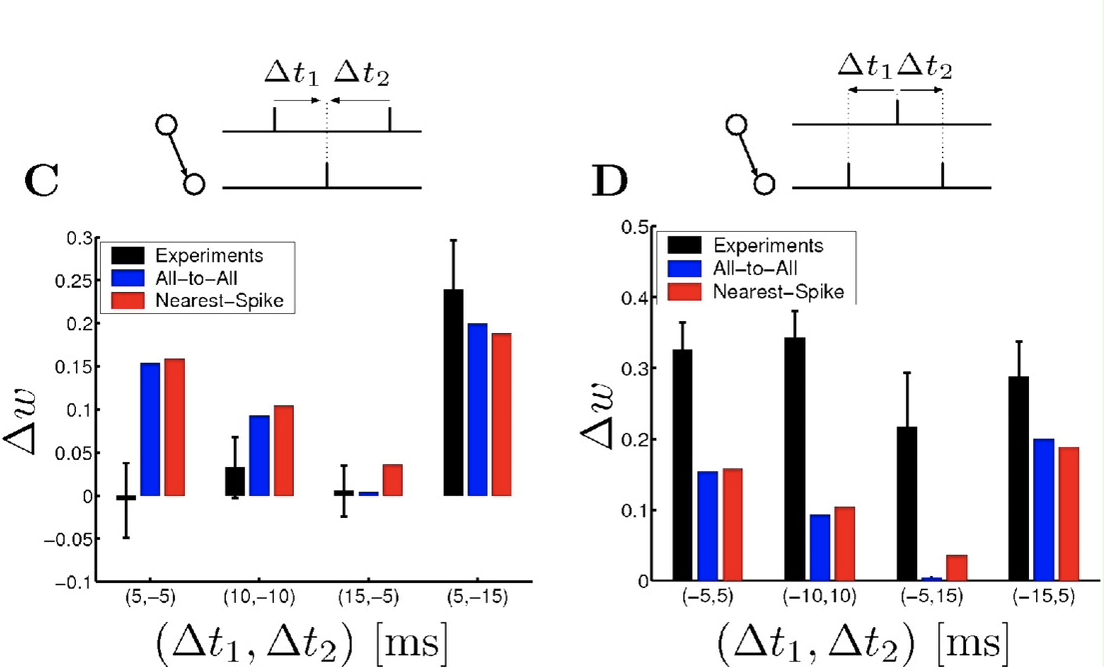
</div>

### Triplet model with triplet protocol

Let us try to formulate the two triplet protocols using the triplet model and check if we can reproduce the asymmetry in the change in weights.

In [15]:
# Simulation
def run_triplet_protocol_simulation(module_name, neuron_model_name, synapse_model_name,
                                    neuron_opts, nest_syn_opts,
                                    spike_delays, n_triplets = 1, triplet_delay = 1000,
                                    pre_post_pre=True):
    dw_vec= []

    # For pre-post-pre triplets
    for _delays in spike_delays:
        pre_spike_times, post_spike_times = create_triplet_spikes(_delays, n_triplets, triplet_delay)
        if not pre_post_pre: # swap the spike arrays
            post_spike_times, pre_spike_times = pre_spike_times, post_spike_times

        sim_time = max(np.amax(pre_spike_times), np.amax(post_spike_times)) + 10. + 3 * syn_opts["delay"]

        print("Simulating for (delta_t1, delta_t2) = ({}, {})".format(_delays[0], _delays[1]))
        dw = run_triplet_stdp_network(module_name, neuron_model_name, synapse_model_name,
                                      neuron_opts, nest_syn_opts,
                                      pre_spike_times=pre_spike_times,
                                      post_spike_times=post_spike_times,
                                      sim_time=sim_time)
        dw_vec.append(dw)
        
    return dw_vec

In [16]:
# All to all - Parameters are taken from [4]
syn_opts = {
        "delay": 1.,
        "tau_minus": 33.7,
        "tau_plus": 16.8,
        "tau_x": 946.,
        "tau_y": 27.,
        "A2_plus": 6.1e-3,
        "A3_plus": 6.7e-3,
        "A2_minus": 1.6e-3,
        "A3_minus": 1.4e-3,
        "Wmax":  50.,
        "Wmin" : 0.,
        "w": 1.
}

synapse_suffix = neuron_model_name[neuron_model_name.find("_with_")+6:]
neuron_opts_nn = {"tau_minus__for_" + synapse_suffix: syn_opts["tau_minus"],
                  "tau_y__for_" + synapse_suffix: syn_opts["tau_y"]}

nest_syn_opts = syn_opts.copy()
nest_syn_opts.pop("tau_minus")
nest_syn_opts.pop("tau_y")

27.0

In [17]:
# Nearest spike - Parameters are taken from [4]
syn_opts_nn = {
        "delay": 1.,
        "tau_minus": 33.7,
        "tau_plus": 16.8,
        "tau_x": 575.,
        "tau_y": 47.,
        "A2_plus": 4.6e-3,
        "A3_plus": 9.1e-3,
        "A2_minus": 3e-3,
        "A3_minus": 7.5e-9,
        "Wmax":  50.,
        "Wmin" : 0.,
        "w": 1.
}

synapse_suffix_nn = neuron_model_name_nn[neuron_model_name_nn.find("_with_")+6:]
neuron_opts_nn = {"tau_minus__for_" + synapse_suffix_nn: syn_opts_nn["tau_minus"],
                  "tau_y__for_" + synapse_suffix_nn: syn_opts_nn["tau_y"]}

nest_syn_opts_nn = syn_opts_nn.copy()
nest_syn_opts_nn.pop("tau_minus")
nest_syn_opts_nn.pop("tau_y")

47.0

### pre-post-pre triplet

In [18]:
pre_post_pre_delays = [(5, -5), (10, -10), (15, -5), (5, -15)]

# All-to-All interation
dw_vec = run_triplet_protocol_simulation(module_name, neuron_model_name, synapse_model_name,
                                         neuron_opts, nest_syn_opts,
                                         pre_post_pre_delays,
                                         n_triplets=1,
                                         triplet_delay=1000)

# Nearest spike interaction
dw_vec_nn = run_triplet_protocol_simulation(module_name_nn, neuron_model_name_nn, synapse_model_name_nn,
                                            neuron_opts_nn, nest_syn_opts_nn,
                                            pre_post_pre_delays,
                                            n_triplets=1,
                                            triplet_delay=1000)

Simulating for (delta_t1, delta_t2) = (5, -5)
Initial weight: 1.0, Updated weight: 1.0050613336422116
Simulating for (delta_t1, delta_t2) = (10, -10)
Initial weight: 1.0, Updated weight: 1.0033041134126772
Simulating for (delta_t1, delta_t2) = (15, -5)
Initial weight: 1.0, Updated weight: 1.0010569740202522
Simulating for (delta_t1, delta_t2) = (5, -15)
Initial weight: 1.0, Updated weight: 1.0060708925921593
Simulating for (delta_t1, delta_t2) = (5, -5)
Initial weight: 1.0, Updated weight: 1.0069212695313912
Simulating for (delta_t1, delta_t2) = (10, -10)
Initial weight: 1.0, Updated weight: 1.0048211690063567
Simulating for (delta_t1, delta_t2) = (15, -5)
Initial weight: 1.0, Updated weight: 1.0026215076729108
Simulating for (delta_t1, delta_t2) = (5, -15)
Initial weight: 1.0, Updated weight: 1.0076053401541742


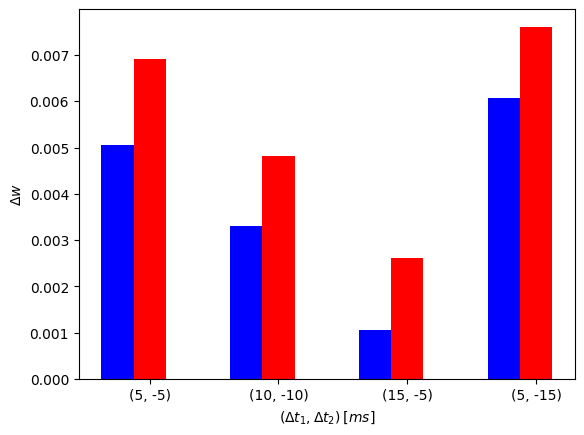

In [21]:
# Plot
bar_width = 0.25
fig, axes = plt.subplots()
br1 = np.arange(len(pre_post_pre_delays))
br2 = [x + bar_width for x in br1]
axes.bar(br1, dw_vec, width=bar_width, color="b")
axes.bar(br2, dw_vec_nn, width=bar_width, color="r")
axes.set_xticks([r + bar_width for r in range(len(br1))])
axes.set_xticklabels(pre_post_pre_delays)
axes.set_xlabel(r"${(\Delta{t_1}, \Delta{t_2})} \: [ms]$")
axes.set_ylabel(r"${\Delta}w$")
plt.show()
plt.close(fig)


### post-pre-post triplet

In [22]:
post_pre_post_delays = [(-5, 5), (-10, 10), (-5, 15), (-15, 5)]

# All-to-All interaction
dw_vec = run_triplet_protocol_simulation(module_name, neuron_model_name, synapse_model_name,
                                         neuron_opts, nest_syn_opts,
                                         post_pre_post_delays,
                                         n_triplets=10,
                                         triplet_delay=1000,
                                         pre_post_pre=False)

# Nearest spike interaction
dw_vec_nn = run_triplet_protocol_simulation(module_name_nn, neuron_model_name_nn, synapse_model_name_nn,
                                            neuron_opts_nn, nest_syn_opts_nn,
                                            post_pre_post_delays,
                                            n_triplets=10,
                                            triplet_delay=1000,
                                            pre_post_pre=False)

Simulating for (delta_t1, delta_t2) = (-5, 5)
Initial weight: 1.0, Updated weight: 1.0874070645368679
Simulating for (delta_t1, delta_t2) = (-10, 10)
Initial weight: 1.0, Updated weight: 1.0589083967386175
Simulating for (delta_t1, delta_t2) = (-5, 15)
Initial weight: 1.0, Updated weight: 1.0322012956591686
Simulating for (delta_t1, delta_t2) = (-15, 5)
Initial weight: 1.0, Updated weight: 1.0927300988828736
Simulating for (delta_t1, delta_t2) = (-5, 5)
Initial weight: 1.0, Updated weight: 1.0596271815518723
Simulating for (delta_t1, delta_t2) = (-10, 10)
Initial weight: 1.0, Updated weight: 1.0410936392338597
Simulating for (delta_t1, delta_t2) = (-5, 15)
Initial weight: 1.0, Updated weight: 1.020929324825549
Simulating for (delta_t1, delta_t2) = (-15, 5)
Initial weight: 1.0, Updated weight: 1.0664678877797031


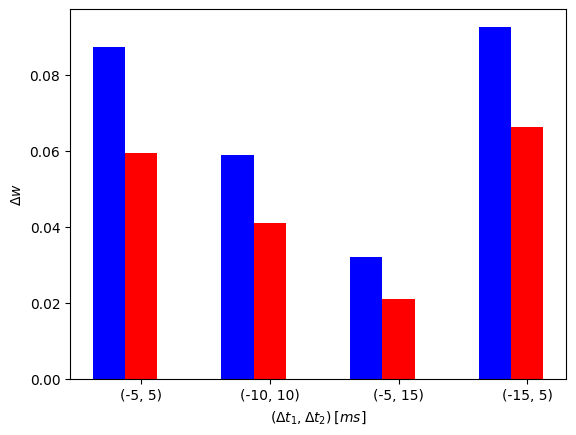

In [24]:
# Plot
bar_width = 0.25
fig, axes = plt.subplots()
br1 = np.arange(len(pre_post_pre_delays))
br2 = [x + bar_width for x in br1]
axes.bar(br1, dw_vec, width=bar_width, color="b")
axes.bar(br2, dw_vec_nn, width=bar_width, color="r")
axes.set_xticks([r + bar_width for r in range(len(br1))])
axes.set_xticklabels(post_pre_post_delays)
axes.set_xlabel(r"${(\Delta{t_1}, \Delta{t_2})} \: [ms]$")
axes.set_ylabel(r"${\Delta}w$")
plt.show()
plt.close(fig)


### Quadruplet protocol

This protocol is with a set of four spikes and defined as follows: a post-pre pair with a delay of $\Delta{t_1} = t_1^{post} - t_1^{pre}< 0$ is followed after a time $T$ with a pre-post pair with a delat of $\Delta{t_2} = t_2^{post} - t_2^{pre} > 0$. When $T$ is negative, a pre-post pair with a delay of $\Delta{t_2} = t_2^{post} - t_2^{pre} > 0$ is  followed by a post-pre pair with delay $\Delta{t_1} = t_1^{post} - t_1^{pre}< 0$.

Try to formulate this protocol using the defined model and reproduce the following weight change window graph.

<div>
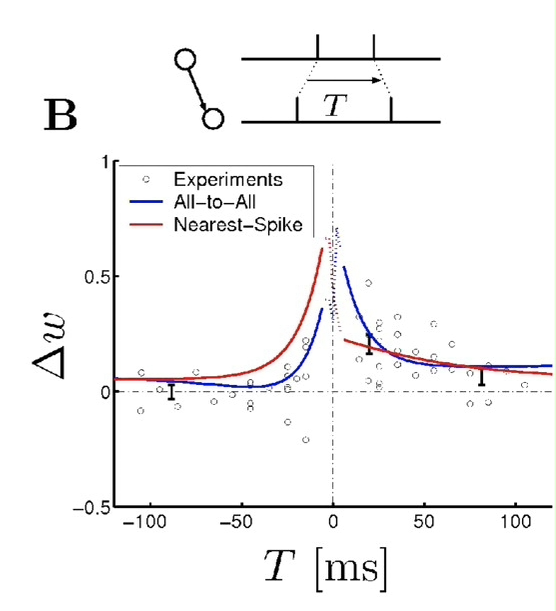
</div>

References
----------

[1] Bi G, Poo M (1998) Synaptic modifications in cultured hippocampal neurons: dependence on spike timing, synaptic strength, and postsynaptic cell type. J Neurosci 18:10464–10472.

[2] Wang HX, Gerkin RC, Nauen DW, Bi GQ (2005) Coactivation and timing-dependent integration of synaptic potentiation and depression. Nat Neurosci 8:187–193.

[3] Sjöström P, Turrigiano G, Nelson S (2001) Rate, timing, and cooperativity jointly determine cortical synaptic plasticity. Neuron 32:1149–1164.CrossRefPubMedGoogle Scholar

[4] J.P. Pfister, W. Gerstner Triplets of spikes in a model of spike-timing-dependent plasticity
J. Neurosci., 26 (2006), pp. 9673-9682

Acknowledgements
----------------

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.